In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# imports we will use
import altair as alt
import pandas as pd
# start with the setup

# supress warnings about future deprecations
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import altair as alt
import numpy as np
import pprint
import datetime as dt
from vega_datasets import data
import matplotlib.pyplot as plt

# Solve a javascript error by explicitly setting the renderer
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
datasetURL="https://raw.githubusercontent.com/eytanadar/si649public/master/lab5/assets/hw/movie_after_1990.csv"
movies_test=pd.read_csv(datasetURL, encoding="latin-1")
#load data 
df1=pd.read_csv("https://raw.githubusercontent.com/dallascard/SI649_public/main/altair_hw3/approval_polllist.csv")
df2=pd.read_csv("https://raw.githubusercontent.com/dallascard/SI649_public/main/altair_hw3/approval_topline.csv")

In [3]:
#TODO: Compare the Box office and Budget of movies that passed the Bechdel test vs failed the test
chart1 = alt.Chart(movies_test).mark_line().transform_calculate(
    box_office=alt.datum.dom_gross + alt.datum.int_gross #can use datum instead of alt.datum
).transform_filter(
    (alt.datum.year >= 1997) & (alt.datum.year <= 2013)
).encode(
    alt.X('year:O'),
    alt.Y('mean(box_office):Q'),
    color='binary'
).properties(
    width = 500
)


chart2 = alt.Chart(movies_test).mark_line().transform_filter(
    
    (alt.datum.year >= 1997) & (alt.datum.year <= 2013)
).encode(
    alt.X('year:O'),
    alt.Y('mean(budget)', scale=alt.Scale(domain=[0, 400000000])),
    color='binary'
).properties(
    width = 500
) 

charts = alt.hconcat(chart1, chart2)
charts

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [4]:
#TODO: Replicate Vis 3 
custom_sort_order = ["Fewer than two women","Passes Bechdel Test", "Women don't talk to each other","Women only talk about men",  "dubious"]

# Create a bar chart for movies made in US and Canada with 'blues' color scale
domestic_chart = alt.Chart(movies_test).transform_filter(
 alt.datum.country_binary == 'U.S. and Canada'
).mark_bar().encode(
    y=alt.Y('test_result:N', title='test_result',sort = custom_sort_order),
    x=alt.X('mean(dom_gross):Q', title='Mean of dom_gross'),
    color=alt.Color('mean(dom_gross):Q', title='Mean of dom_gross', scale=alt.Scale(scheme='blues'))
).properties(title='Mean Domestic Gross Based on Bechdel Test Result (U.S. and Canada)')


# Create a bar chart for movies made internationally with 'reds' color scale
international_chart = alt.Chart(movies_test).transform_filter(
 alt.datum.country_binary != 'U.S. and Canada'    
).mark_bar().encode(
    y=alt.Y('test_result:N', title='test_result', sort = custom_sort_order),
    x=alt.X('mean(int_gross):Q', title='Mean of Int_gross'),
    color=alt.Color('mean(int_gross):Q', title='Mean of Int_gross', scale=alt.Scale(scheme='reds'))
).properties(title='Mean International Gross Based on Bechdel Test Result (International)')


# Concatenate both charts with independent color scales
combined_chart = alt.vconcat(domestic_chart, international_chart, spacing=10).resolve_scale(color='independent',x ='shared')

# Show the combined chart
combined_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [5]:
#TODO: Replicate Vis 4
heatmap_data = movies_test[movies_test['test_result'] != 'dubious']

bins = alt.Bin(extent=[2, 10], step=1)  

heat = alt.Chart(heatmap_data).mark_rect().encode(
    x=alt.X('rating:Q', bin=bins, title= 'rating (binned)'),
    y=alt.Y('test_result:N', title='test_result'),
    color=alt.Color('count():Q', scale=alt.Scale(scheme='yellowgreenblue'), title='Count of Records'),
    tooltip=[alt.Tooltip('count()', title='Count')]
).properties(
    width=650,
    height=120,  
)

text = alt.Chart(heatmap_data).mark_text(baseline='middle', fontSize=16).encode(
    x=alt.X('rating:Q', bin=bins),
    y=alt.Y('test_result:N'),
    text=alt.Text('count():Q'),
    color=alt.value('black'),  
    tooltip=[alt.Tooltip('count()', title='Count')]
)


final_chart = (heat + text).configure_axis(
    labelFontSize=13,
    titleFontSize=14   
).configure_legend(
    titleFontSize=12, 
    labelFontSize=12  
).properties(
    width = 900
)

final_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [6]:
df1['approve_percent']=df1['approve']/100

# Brush over the bars

In [7]:
brush = alt.selection_interval(encodings=['y'])
mean_approve = df1.groupby('pollster')['approve_percent'].mean().reset_index()

# Create Altair Chart
chart = alt.Chart(mean_approve).mark_bar(size = 15).encode(
    y= alt.Y('pollster:N',axis=alt.Axis(title=None)),
    x= alt.X('approve_percent:Q', axis=alt.Axis(title=None)), 
    tooltip = alt.Tooltip('mean(approve_percent)', format ='.0%'),
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.6)),
).properties(
    title='Average Approval Rating for Joe Biden',
    width = 600
).add_params(
    brush
)

## Static Component - Vertical Line

line = alt.Chart().mark_rule(color='firebrick').encode(
    x='mean(approve_percent):Q',
    size=alt.SizeValue(3),
).transform_filter(
    brush
)

text = alt.Chart(mean_approve).mark_text(
    align='left',
    baseline='line-top',
    dx=7,
    fontSize=12,
    color='firebrick'
).encode(
    x=alt.value(527),
    text=alt.Text('mean(approve_percent):Q', format='.2%')
).transform_filter(
    brush
)


base = alt.layer(chart, line, text, data=df1)

# Combine the chart and the line
compound_chart = base.configure_view(strokeWidth=0)

# Display the compound chart
compound_chart.configure_text(color='firebrick', fontSize=12, align='left', dx=7)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Try brushing over the scatter plot

In [8]:
# brush = alt.selection_interval()
brush = alt.selection_interval(encodings=['x'])

scatter_plot = alt.Chart(df1).mark_point(opacity=0.5, filled = True).encode(
    x= alt.X('startdate:T', title = None),
    y= alt.Y('approve_percent:Q', title = 'approval rating'),
    color='pollster:N'
).properties(
    title='Recently Voted Approve Rate for Joe Biden',
    width = 300
)

selection = alt.selection_interval(encodings = ['x'], value={"x":[60,150],"y":[15,30]}) #value = initialize
# print(selection)
colorCondition = alt.condition(brush,"pollster",alt.value("gray"))

scatter_plot = scatter_plot.add_params(brush).encode(
    color=colorCondition
)

bar_chart = alt.Chart(df1).mark_bar().encode(
    y=alt.Y('pollster:N', title = None),
    x= alt.X('mean(approve_percent):Q', title = 'mean of approval ratings'),
    # color=alt.value('lightgray')
    color = 'pollster:N'
).transform_filter(
    brush
)

compound_chart = (scatter_plot & bar_chart).configure_view(strokeWidth=0)

compound_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
# fix the time stamps and reorganize the data to combine approve and disapprove into one column
df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2=pd.melt(df2, id_vars=['president', 'subgroup', 'timestamp'], value_vars=['approve','disapprove']).rename(columns={'variable':'choice', 'value':'rate'})
df2.head()

president   subgroup           timestamp   choice       rate
0  Joe Biden  All polls 2023-02-14 09:24:00  approve  43.108745
1  Joe Biden     Adults 2023-02-14 09:24:00  approve  41.936438
2  Joe Biden     Voters 2023-02-14 09:25:00  approve  44.082005
3  Joe Biden  All polls 2023-02-13 19:23:00  approve  42.822155
4  Joe Biden     Adults 2023-02-13 19:24:00  approve  41.936438

# Brush over the plot

In [10]:
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['timestamp'], empty='none')

# The basic line
line = alt.Chart().mark_line(interpolate='basis').encode(
    alt.X('timestamp:T', axis=alt.Axis(title='')),
    alt.Y('mean(rate):Q', axis=alt.Axis(title='rate')),
    color='choice:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='timestamp:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'mean(rate):Q', alt.value(' '), format='.2f')
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='timestamp:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
newchart = alt.layer(line, selectors, points, rules, text,
                       data=df2, 
                       width=300, height=300,title='Stock History')
# stockChart.save('stocks.html')
newchart

selection = alt.selection_interval(bind="scales",encodings=["x"]) # pans across x axis

new = newchart.add_params(selection).encode(
    color="choice:N"
).properties(title="Approval Rating for Joe Biden 2022-2023")

new 

/Users/shreya/anaconda3/envs/SI649/lib/python3.12/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection' is deprecated.
   Use 'selection_point()' or 'selection_interval()' instead; these functions also include more helpful docstrings.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/shreya/anaconda3/envs/SI649/lib/python3.12/site-packages/altair/vegalite/v5/api.py:469: AltairDeprecationWarning: The types 'single' and 'multi' are now
        combined and should be specified using "selection_point()".
  warnings.warn(
/Users/shreya/anaconda3/envs/SI649/lib/python3.12/site-packages/altair/vegalite/v5/api.py:398: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/Users/shreya/anaconda3/envs/SI649/lib/python3.12/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [12]:
pn.extension('vega')

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import altair as alt
import numpy as np
import pprint
import datetime as dt
from vega_datasets import data
#import matplotlib.pyplot as plt
import panel as pn
import vega_datasets
import datetime as dt


df2=pd.read_csv("https://raw.githubusercontent.com/dallascard/SI649_public/main/altair_hw3/approval_topline.csv")

df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2['smoothed'] = df2['approve'].rolling(window=df2.shape[0], min_periods=1).mean().shift()
df2=pd.melt(df2, id_vars=['president', 'subgroup', 'timestamp','smoothed'], value_vars=['approve','disapprove']).rename(columns={'variable':'choice', 'value':'rate'})

# Slider 

select = pn.widgets.Select(name='Select',options=df2['subgroup'].unique().tolist())

d_min = df2["timestamp"].min()
d_max = df2["timestamp"].max()
date_range_slider = pn.widgets.DateRangeSlider(
    name='Date Range Slider',
    start=d_min.date(), end=d_max.date(),
    value=(d_min.date(), d_max.date()),
    step=1
)

mov_avg_window = pn.widgets.IntSlider(name='Moving Average Window', start=1, end=50, value=1) 

@pn.depends(select.param.value, date_range_slider.param.value, mov_avg_window.param.value)

def get_plot(select, date_range, mov_avg_window):     # Load and format the data
    df2=pd.read_csv("https://raw.githubusercontent.com/dallascard/SI649_public/main/altair_hw3/approval_topline.csv")

 
    # fix the time stamps and reorganize the data to combine approve and disapprove into one column
    df2['timestamp']=pd.to_datetime(df2['timestamp'])
    df2['smoothed'] = df2['approve'].rolling(window=df2.shape[0], min_periods=1).mean().shift()
    df2=pd.melt(df2, id_vars=['president', 'subgroup', 'timestamp'], value_vars=['approve','disapprove']).rename(columns={'variable':'choice', 'value':'rate'})

    dt1 = date_range_slider.value[0]

    dt2 = date_range_slider.value[1]

    d_min = dt.datetime(
    year=dt1.year, 
    month=dt1.month,
    day=dt1.day,)

    d_max=dt.datetime(
    year=dt2.year, 
    month=dt2.month,
    day=dt2.day,)
    
    mask = (df2['timestamp'] >= d_min) & (df2['timestamp'] <= d_max)
    
    df2 = df2.loc[mask] # filter the dataframe     # create the Altair chart object
      
    chart = alt.Chart(df2).mark_circle().encode(
    x = alt.X('timestamp:T', axis=alt.Axis(title='')),
    y = alt.Y('rate:Q', scale=alt.Scale(domain=[30, 60])),
    color=alt.value('grey')).transform_filter((alt.datum.choice=='approve') & (alt.datum.subgroup == select))

    line = (
    alt.Chart(df2)
    .encode(
        x='timestamp:T',
        y=alt.Y('rate:Q')).transform_filter((alt.datum.choice=='approve') & (alt.datum.subgroup == select)
    ).mark_line(color='red', size = 2)
    )
    # .transform_loess(
#         on = "timestamp:T",
#         loess = "rate:Q",
#        bandwidth = 3
#     )
#     .mark_line()
# )
    return chart + line 

dashboard = pn.Column(
    pn.panel(get_plot),
    pn.Column(select, date_range_slider, mov_avg_window)
)

dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'ee98c02c-630c-4dcd-b6d5-f8a1be304565': {'version…

# Tableau

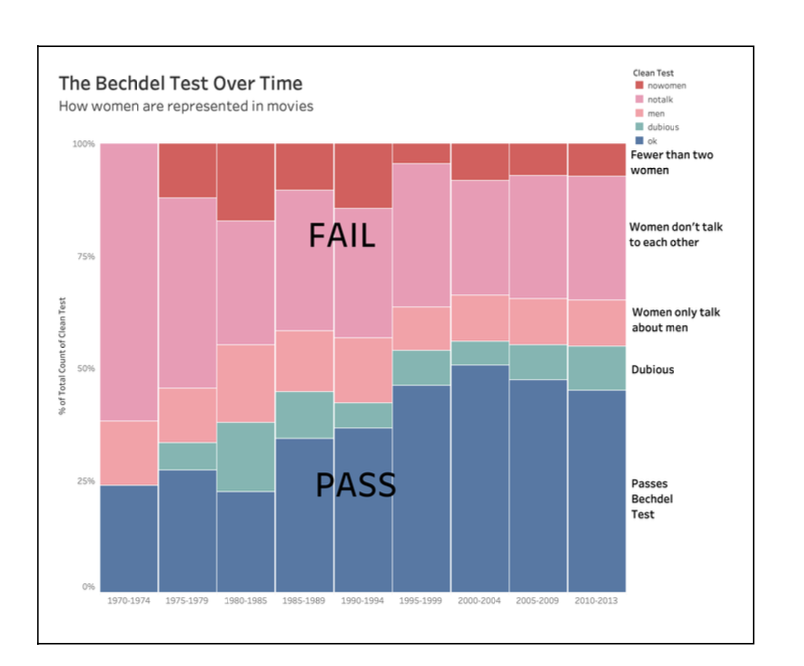
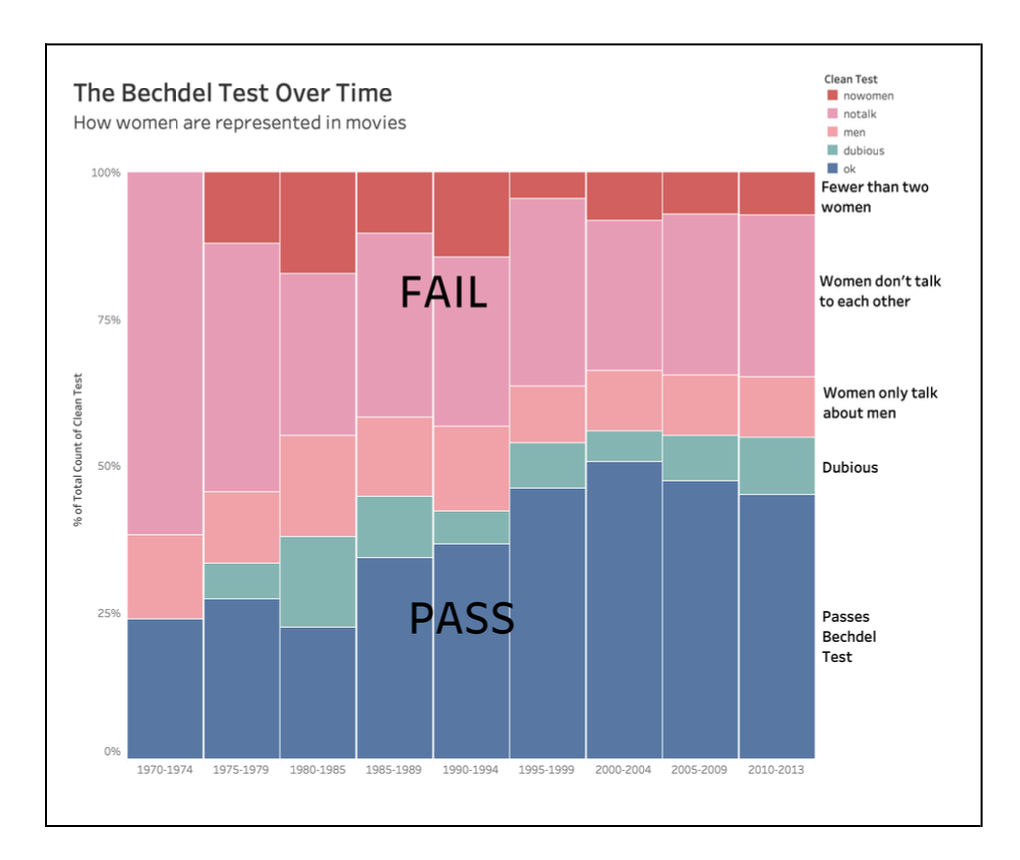

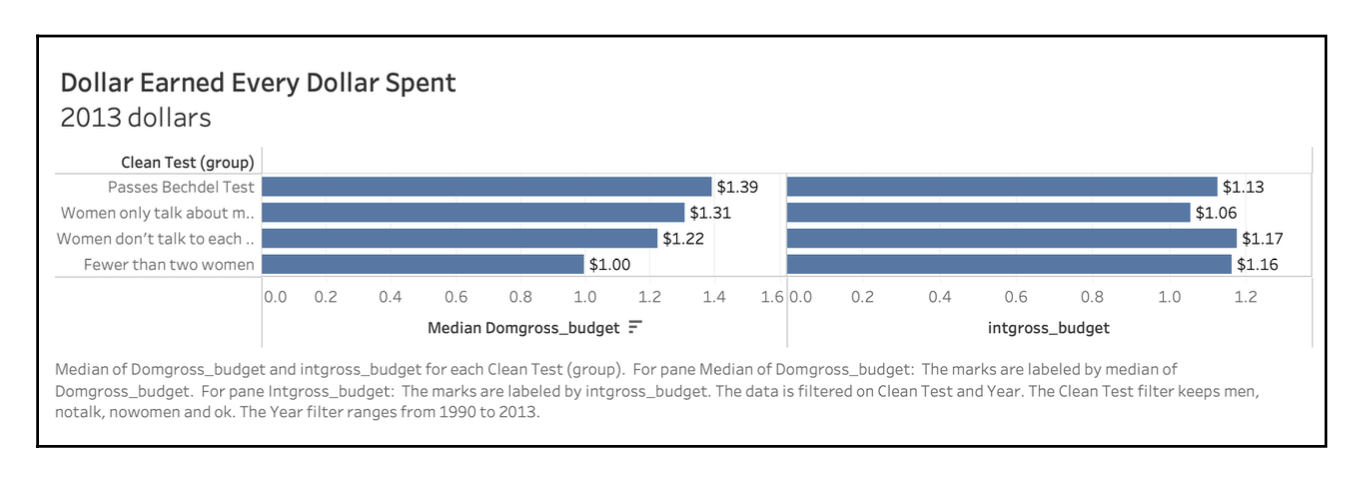

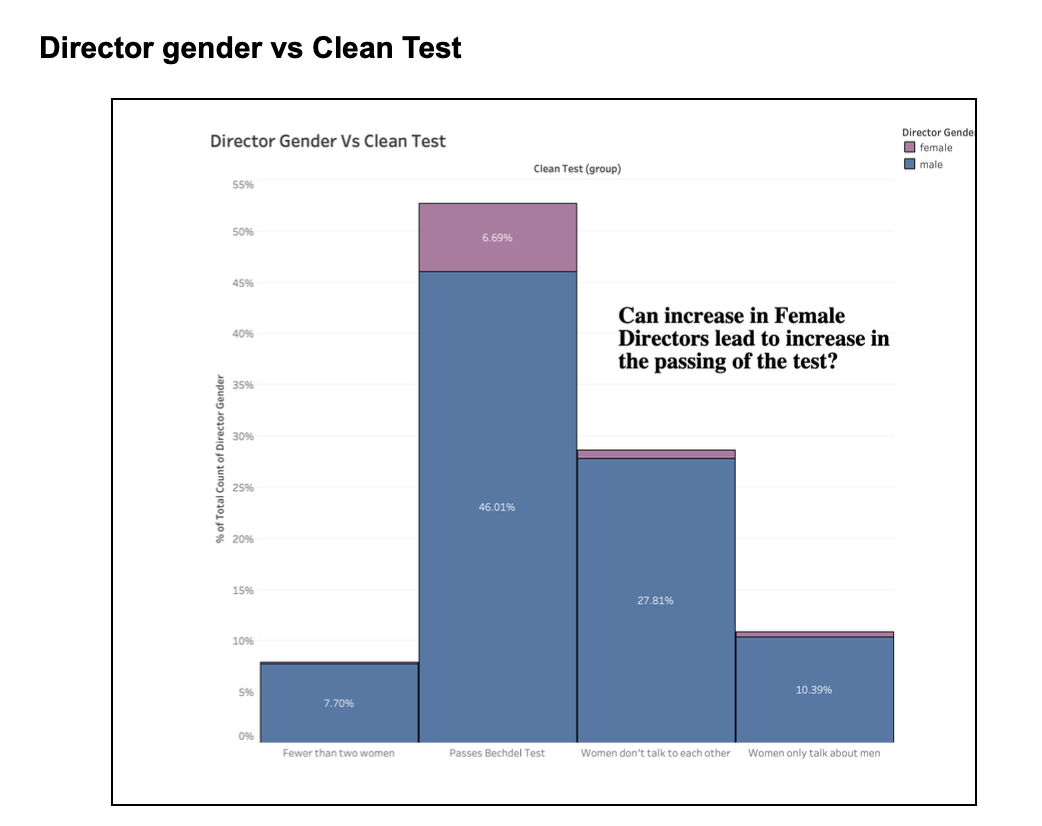
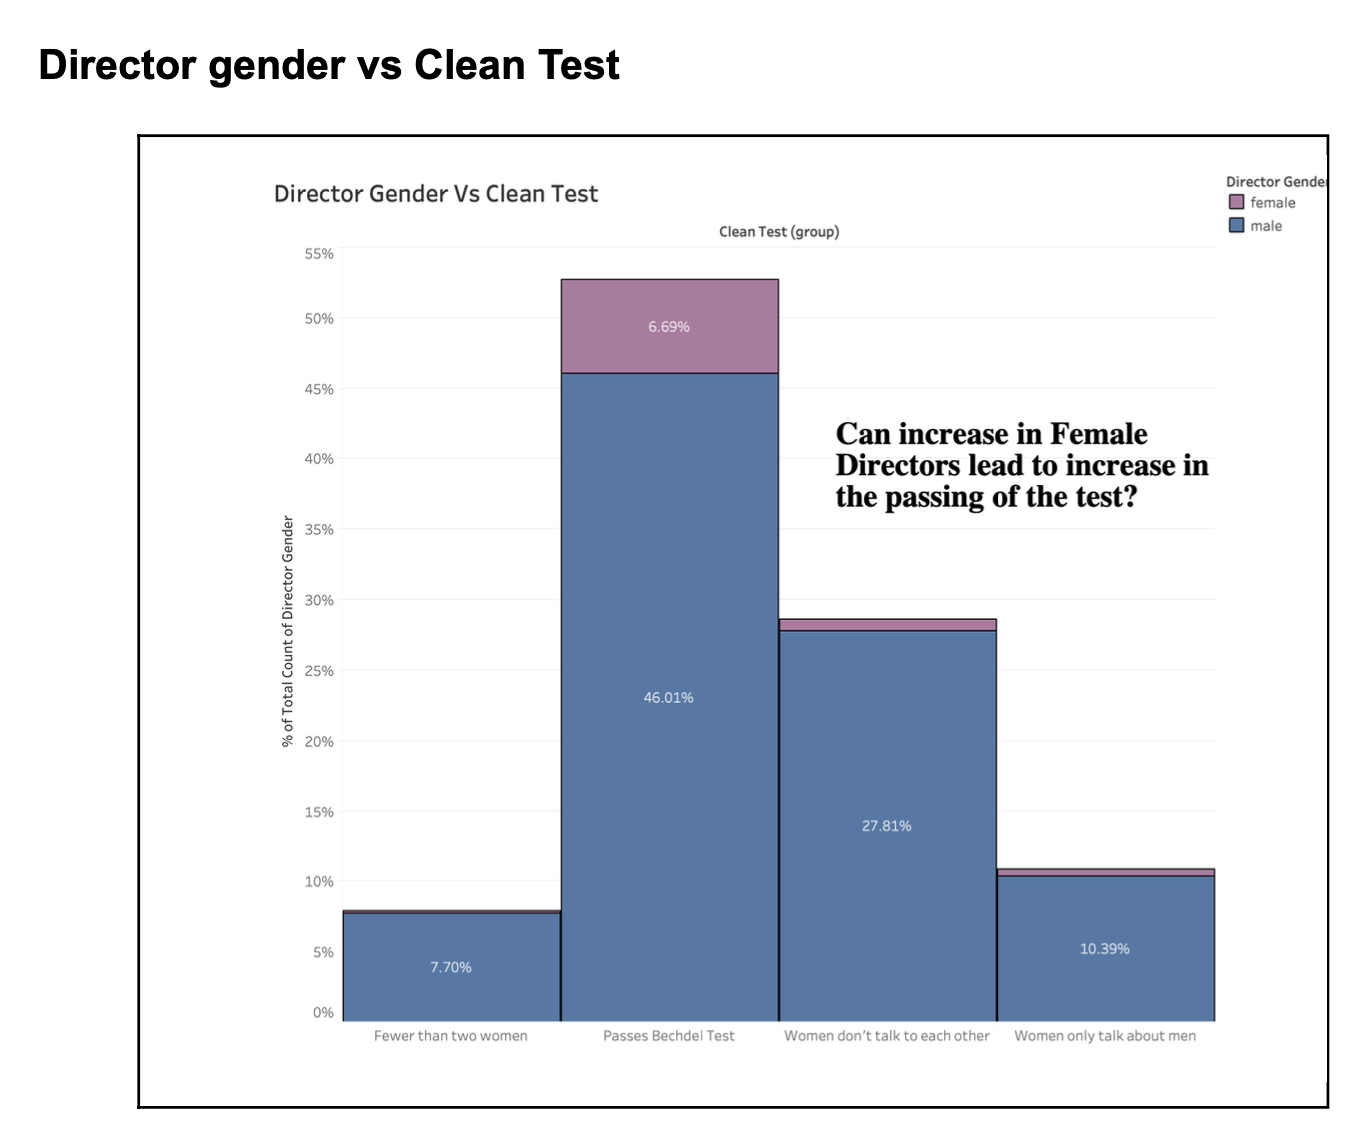

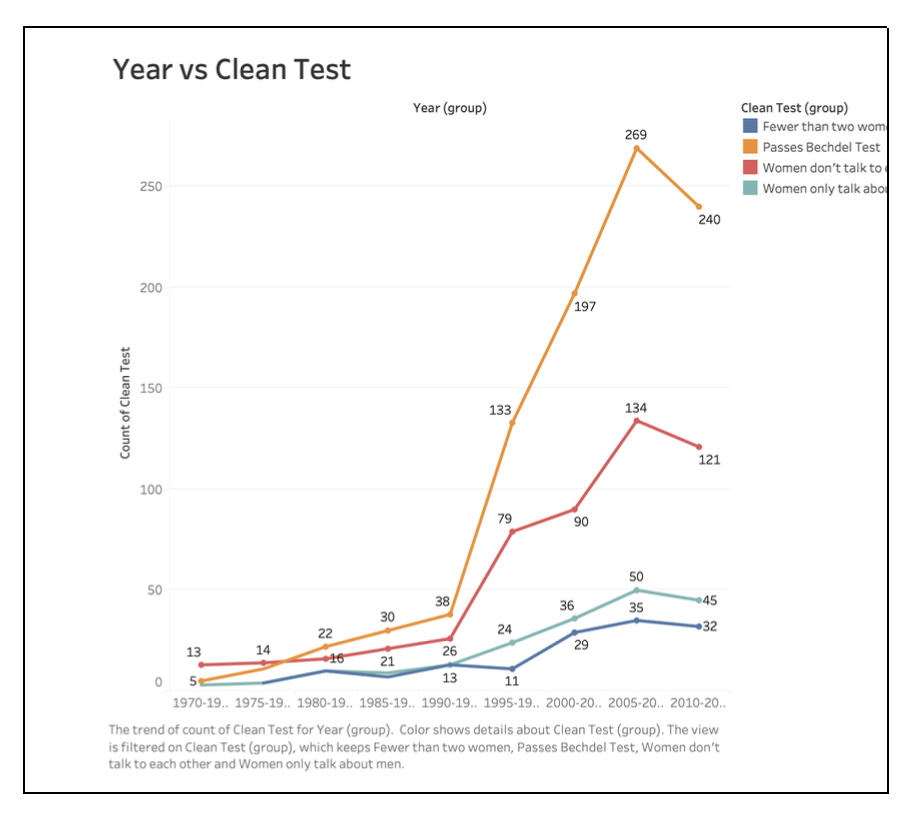

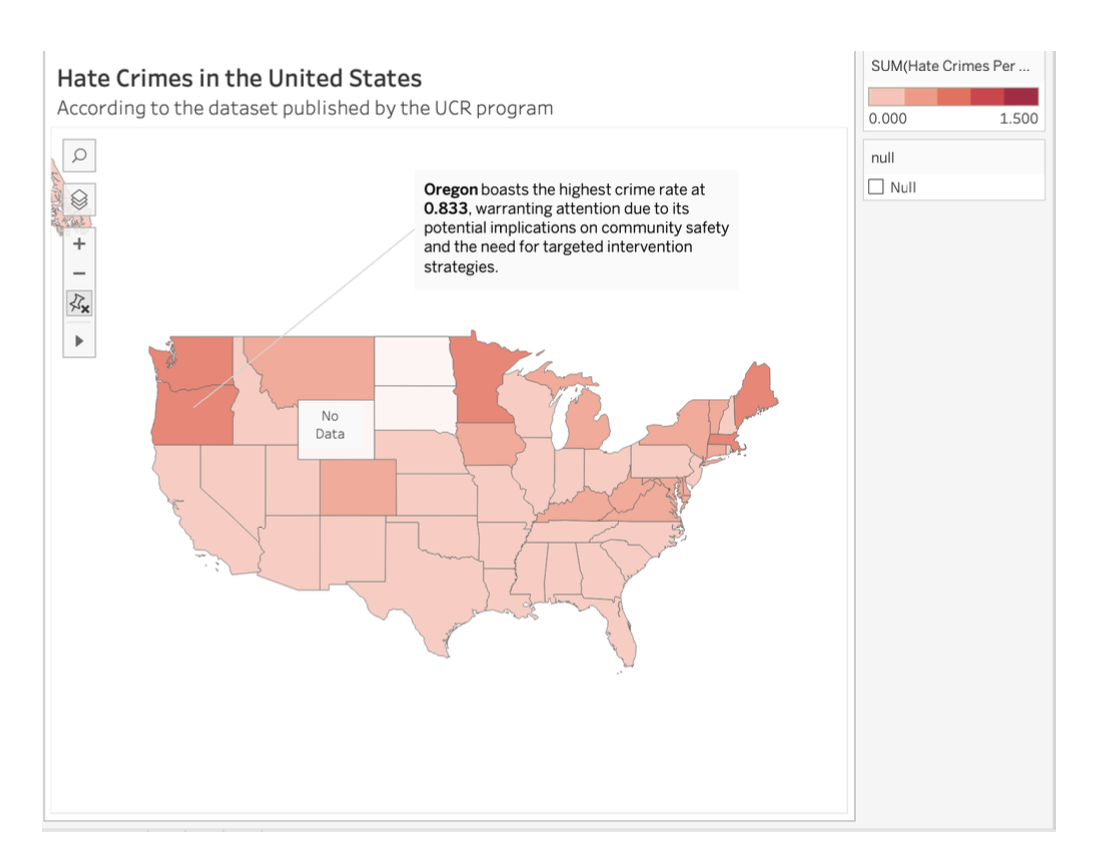

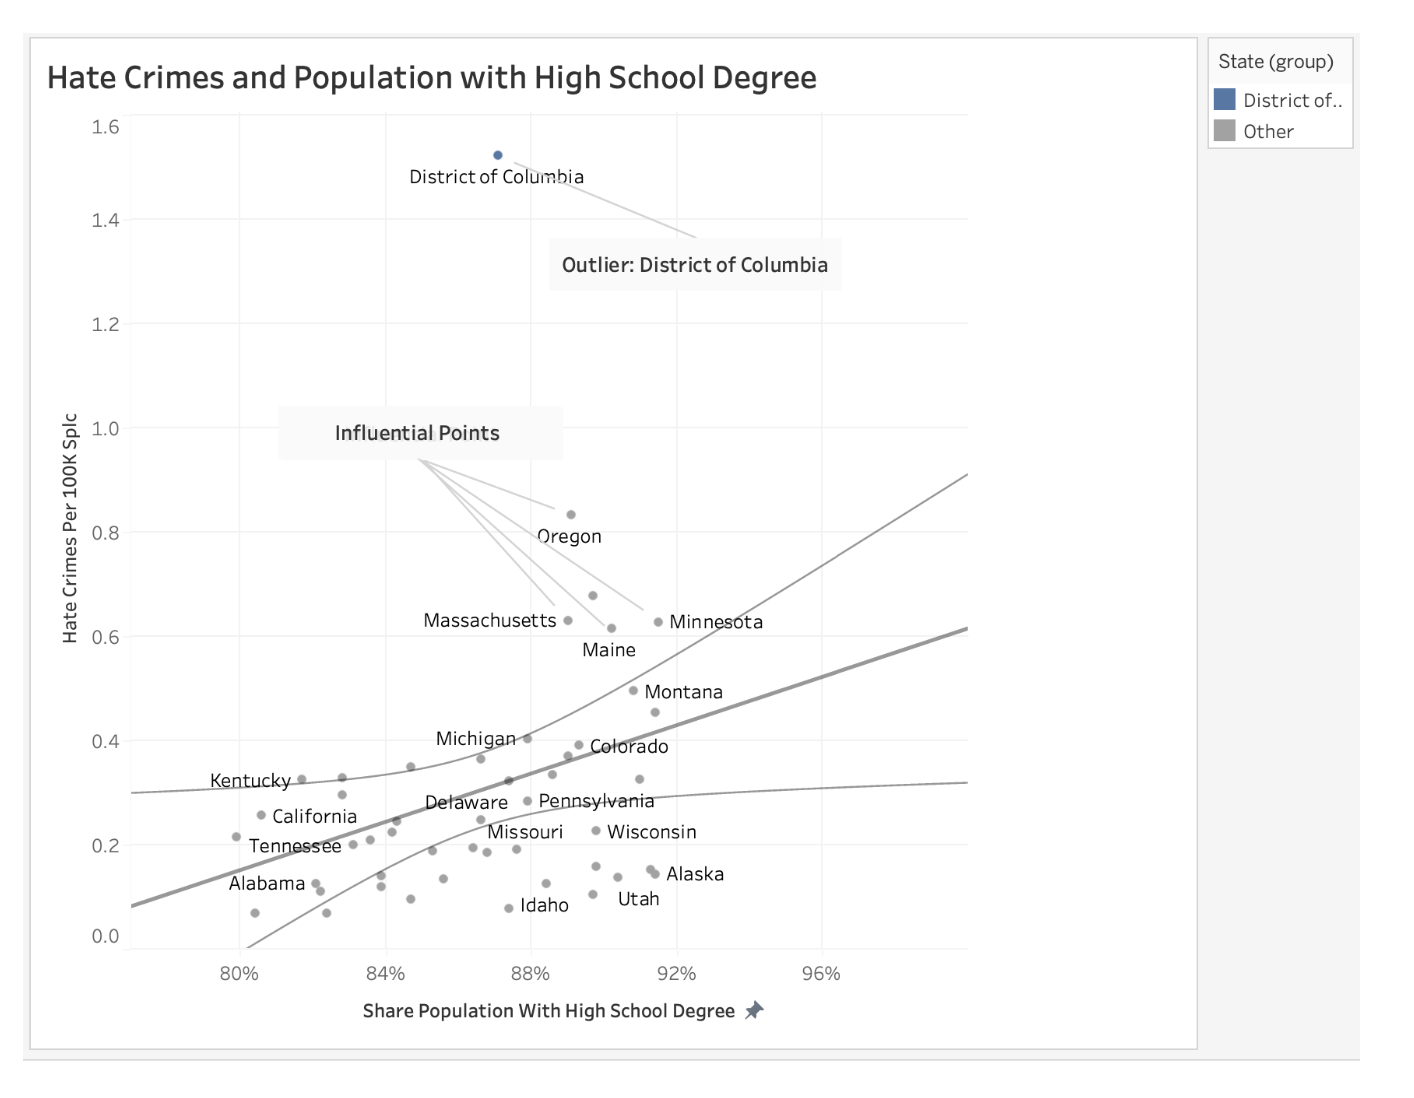

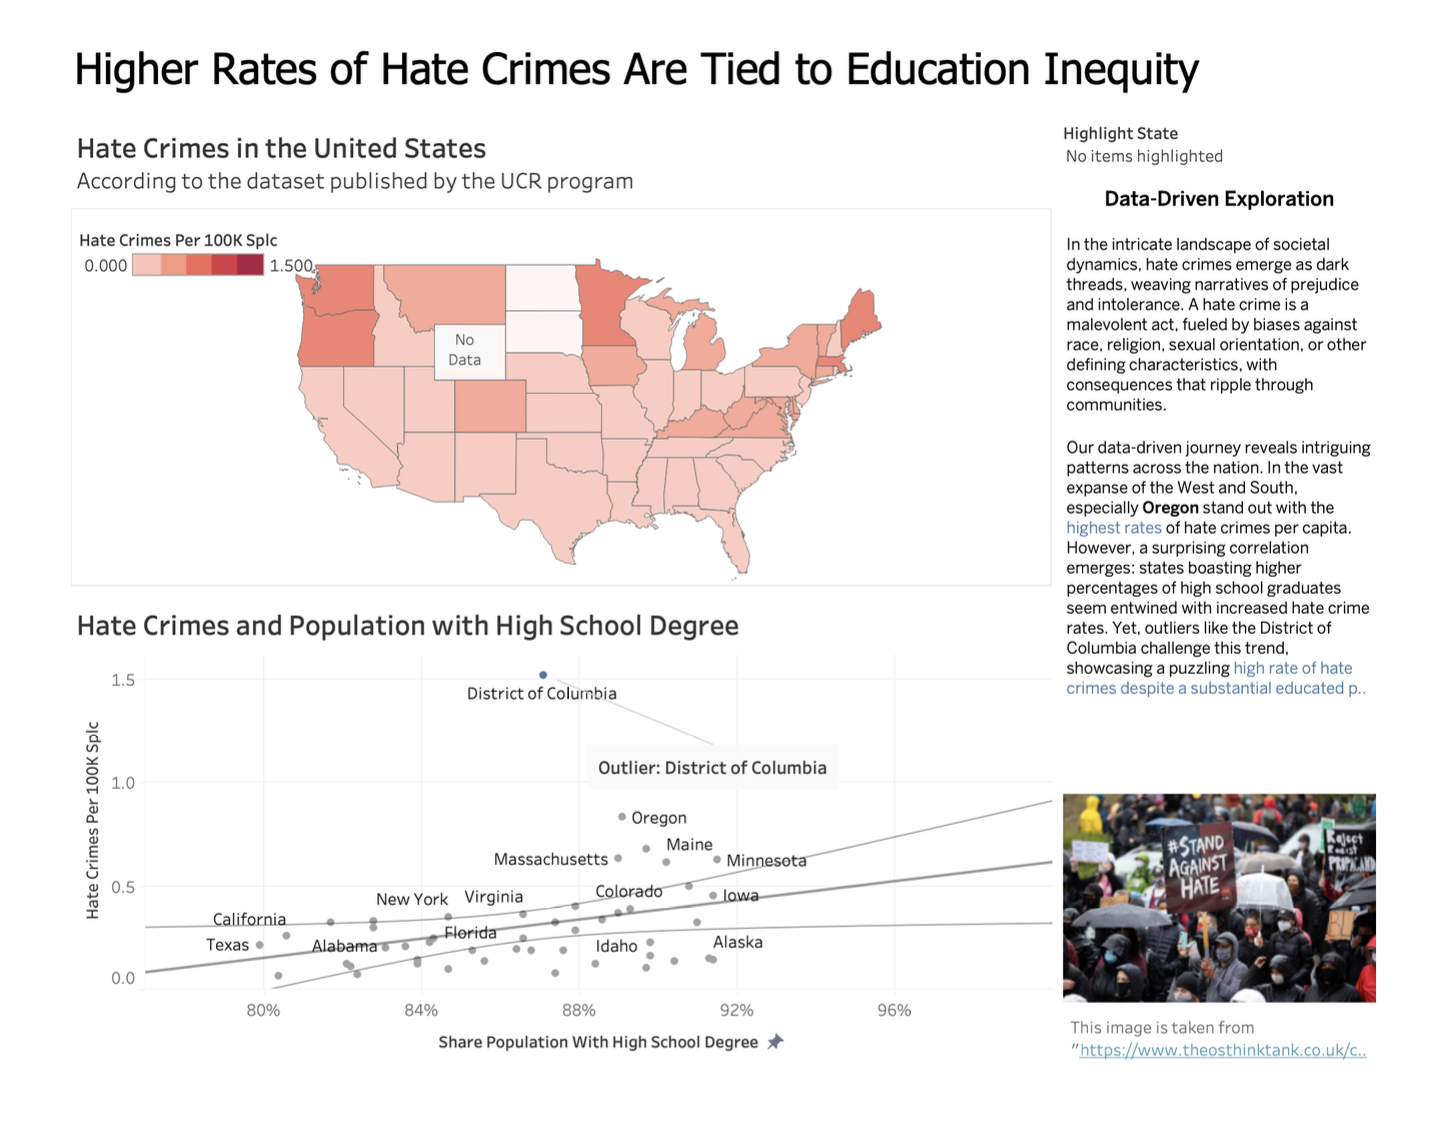